In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
from transformers import AutoImageProcessor, AutoModelForImageClassification
from PIL import Image


c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [8]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [4]:
stage1_dataset = datasets.ImageFolder(root='Rice 2', transform=transform)
train_size = int(0.8 * len(stage1_dataset))
val_size = len(stage1_dataset) - train_size
train_dataset, val_dataset = random_split(stage1_dataset, [train_size, val_size])

# DataLoaders for Stage 1
train_loader_stage1 = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader_stage1 = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [5]:
resnet_model = models.resnet50(weights='DEFAULT')
processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")
vit_model = AutoModelForImageClassification.from_pretrained("google/vit-base-patch16-224")

# Freeze pretrained layers if desired
for param in resnet_model.parameters():
    param.requires_grad = False
for param in vit_model.parameters():
    param.requires_grad = False


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [13]:
class CombinedModel(nn.Module):
    def __init__(self, resnet_model, vit_model, num_classes):
        super(CombinedModel, self).__init__()
        self.resnet = resnet_model
        self.vit = vit_model
        self.fc = nn.Linear(1000 + 1000, num_classes)

    def forward(self, x):
        resnet_features = self.resnet(x)
        vit_features = self.vit(x).logits
        combined_features = torch.cat((resnet_features, vit_features), dim=1)
        return self.fc(combined_features)

In [14]:
model_stage1 = CombinedModel(resnet_model, vit_model, num_classes=2)
model_stage1 = model_stage1.to(device)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_stage1.fc.parameters(), lr=0.001)


In [9]:
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}, Accuracy: {correct/total}")


In [11]:
def evaluate_model(model, val_loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = running_loss / len(val_loader)
    val_accuracy = correct / total
    return val_loss, val_accuracy

In [12]:
print("Training Stage 1 Model for Healthy/Unhealthy Classification")
train_model(model_stage1, train_loader_stage1, criterion, optimizer, num_epochs=10)
val_loss_stage1, val_accuracy_stage1 = evaluate_model(model_stage1, val_loader_stage1, criterion)
print(f"Stage 1 - Validation Loss: {val_loss_stage1:.4f}, Validation Accuracy: {val_accuracy_stage1:.4f}")

Training Stage 1 Model for Healthy/Unhealthy Classification
Epoch [1/10], Loss: 0.3412163329913336, Accuracy: 0.8320049049662783
Epoch [2/10], Loss: 0.2661845065361145, Accuracy: 0.8816676885346413
Epoch [3/10], Loss: 0.2527842124303182, Accuracy: 0.8871857755977928
Epoch [4/10], Loss: 0.22150891858573055, Accuracy: 0.9064990803188228
Epoch [5/10], Loss: 0.21456784404375973, Accuracy: 0.9129368485591661
Epoch [6/10], Loss: 0.2133763494590918, Accuracy: 0.9083384426732066
Epoch [7/10], Loss: 0.19811357243680486, Accuracy: 0.9114040465971797
Epoch [8/10], Loss: 0.18926696329578466, Accuracy: 0.9224402207234825
Epoch [9/10], Loss: 0.18717359298584507, Accuracy: 0.9187614960147149
Epoch [10/10], Loss: 0.1925455767880468, Accuracy: 0.916922133660331
Stage 1 - Validation Loss: 0.3017, Validation Accuracy: 0.8578


In [15]:
val_loss_stage1, val_accuracy_stage1 = evaluate_model(model_stage1, train_loader_stage1, criterion)
print(f"Stage 1 - Validation Loss: {val_loss_stage1:.4f}, Validation Accuracy: {val_accuracy_stage1:.4f}")

Stage 1 - Validation Loss: 0.1932, Validation Accuracy: 0.9123


In [13]:
torch.save(model_stage1.state_dict(), 'healthy_unhealthy_model.pth')


In [16]:
stage2_dataset = datasets.ImageFolder(root='Rice 2/Unhealthy', transform=transform)
train_size = int(0.8 * len(stage2_dataset))
val_size = len(stage2_dataset) - train_size
train_dataset, val_dataset = random_split(stage2_dataset, [train_size, val_size])

# DataLoaders for Stage 2
train_loader_stage2 = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader_stage2 = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [15]:
model_stage2 = CombinedModel(resnet_model, vit_model, num_classes=3)
model_stage2 = model_stage2.to(device)

In [18]:
optimizer_stage2 = optim.Adam(model_stage2.fc.parameters(), lr=0.001)


In [20]:
print("Training Stage 2 Model for Disease Classification")
train_model(model_stage2, train_loader_stage2, criterion, optimizer_stage2, num_epochs=10)


Training Stage 2 Model for Disease Classification
Epoch [1/10], Loss: 0.35992651742238263, Accuracy: 0.832046332046332
Epoch [2/10], Loss: 0.2855639766042049, Accuracy: 0.8764478764478765
Epoch [3/10], Loss: 0.2419741895336371, Accuracy: 0.903957528957529
Epoch [4/10], Loss: 0.21147118428578743, Accuracy: 0.9184362934362934
Epoch [5/10], Loss: 0.19808868639744245, Accuracy: 0.9198841698841699
Epoch [6/10], Loss: 0.18729635912638445, Accuracy: 0.9203667953667953
Epoch [7/10], Loss: 0.17607925878121303, Accuracy: 0.930984555984556
Epoch [8/10], Loss: 0.1794149798842577, Accuracy: 0.9242277992277992
Epoch [9/10], Loss: 0.17631407884451059, Accuracy: 0.9261583011583011
Epoch [10/10], Loss: 0.176125684265907, Accuracy: 0.9285714285714286


In [22]:
val_loss_stage2, val_accuracy_stage2 = evaluate_model(model_stage2, train_loader_stage2, criterion)
print(f"Stage 2 - Validation Loss: {val_loss_stage2:.4f}, Validation Accuracy: {val_accuracy_stage2:.4f}")

Stage 2 - Validation Loss: 0.1427, Validation Accuracy: 0.9440


In [23]:
torch.save(model_stage2.state_dict(), 'disease_classification_model.pth')


In [24]:
def classify_image(image, model_stage1, model_stage2):
    model_stage1.eval()
    model_stage2.eval()
    image = image.to(device)

    with torch.no_grad():
        # Stage 1: Healthy vs Unhealthy
        output_stage1 = model_stage1(image)
        _, pred_stage1 = torch.max(output_stage1, 1)
        
        if pred_stage1.item() == 0:
            return "Healthy"
        else:
            # Stage 2: Disease type classification
            output_stage2 = model_stage2(image)
            _, pred_stage2 = torch.max(output_stage2, 1)
            classes_stage2 = ['Brown_Spot', 'Leaf_Blast', 'Neck_Blast']
            return classes_stage2[pred_stage2.item()]

In [31]:
from PIL import Image
import torch

# Load the image and preprocess it
image_path = 'Rice 2\Healthy\IMG_3027.jpg'
image = Image.open(image_path)
image = transform(image).unsqueeze(0)  # Add batch dimension

# Set the model to evaluation mode
model_stage1.eval()
image = image.to(device)

# Perform classification with only Stage 1 model
with torch.no_grad():
    output_stage1 = model_stage1(image)
    _, pred_stage1 = torch.max(output_stage1, 1)

# Determine and print the result
if pred_stage1.item() == 0:
    classification = "Healthy"
else:
    classification = "Unhealthy"

print(f"Classification Result: {classification}")


Classification Result: Healthy


In [33]:
import os
from PIL import Image
import torch

# Set directory path
directory_path = 'Rice 2/Healthy'

# Set the model to evaluation mode
model_stage1.eval()

# Function to classify an image as Healthy or Unhealthy
def classify_single_image(image_path, model, transform):
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)  # Add batch dimension
    image = image.to(device)

    with torch.no_grad():
        output = model(image)
        _, pred = torch.max(output, 1)

    return "Healthy" if pred.item() == 0 else "Unhealthy"

# Initialize counters
healthy_count = 0
unhealthy_count = 0

# Iterate over all images in the directory and classify them
for filename in os.listdir(directory_path):
    file_path = os.path.join(directory_path, filename)
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):  # Check if it's an image file
        classification = classify_single_image(file_path, model_stage1, transform)
        
        # Update counters based on classification result
        if classification == "Healthy":
            healthy_count += 1
        else:
            unhealthy_count += 1

# Print classification summary
print("Classification Summary:")
print(f"Total Healthy images: {healthy_count}")
print(f"Total Unhealthy images: {unhealthy_count}")


Classification Summary:
Total Healthy images: 1284
Total Unhealthy images: 204


Checking Healthy directory: True
Checking Unhealthy directory: True


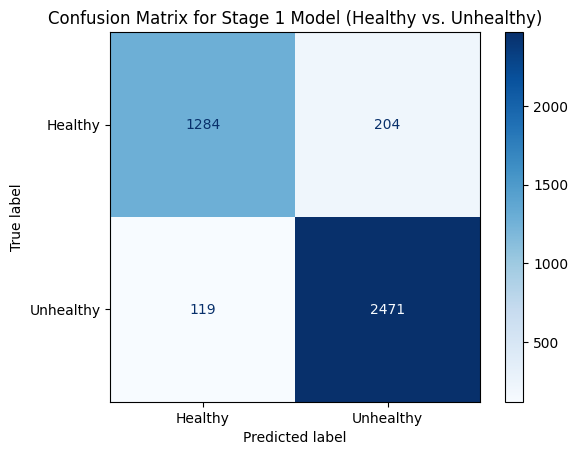

In [ ]:
import os
from PIL import Image
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Set model to evaluation mode
model_stage1.eval()

# Function to classify a single image as Healthy or Unhealthy
def classify_single_image(image_path, model, transform):
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)  # Add batch dimension
    image = image.to(device)

    with torch.no_grad():
        output = model(image)
        _, pred = torch.max(output, 1)

    return pred.item()  # 0 for Healthy, 1 for Unhealthy

# Initialize lists to store true and predicted labels
true_labels = []
predicted_labels = []

healthy_dir = 'Rice 2/Healthy'
unhealthy_dir = 'Rice 2/Unhealthy'

# Debugging: Check if directories exist
print(f"Checking Healthy directory: {os.path.exists(healthy_dir)}")
print(f"Checking Unhealthy directory: {os.path.exists(unhealthy_dir)}")

# Function to iterate through directories and classify images
def classify_images_in_directory(directory, label):
    for root, _, files in os.walk(directory):  # os.walk handles subdirectories
        for filename in files:
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                file_path = os.path.join(root, filename)
                true_labels.append(label)
                predicted_labels.append(classify_single_image(file_path, model_stage1, transform))

# Classify all images in the Healthy directory
for filename in os.listdir(healthy_dir):
    file_path = os.path.join(healthy_dir, filename)
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        true_labels.append(0)  # Label 0 for Healthy
        predicted_labels.append(classify_single_image(file_path, model_stage1, transform))

# Classify all images in the Unhealthy directory (including subdirectories)
classify_images_in_directory(unhealthy_dir, 1)  # Label 1 for Unhealthy

# Check if no images were classified
if len(true_labels) == 0:
    print("No images classified. Check directory paths and file extensions.")

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=[0, 1])

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Healthy", "Unhealthy"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Stage 1 Model (Healthy vs. Unhealthy)")
plt.show()


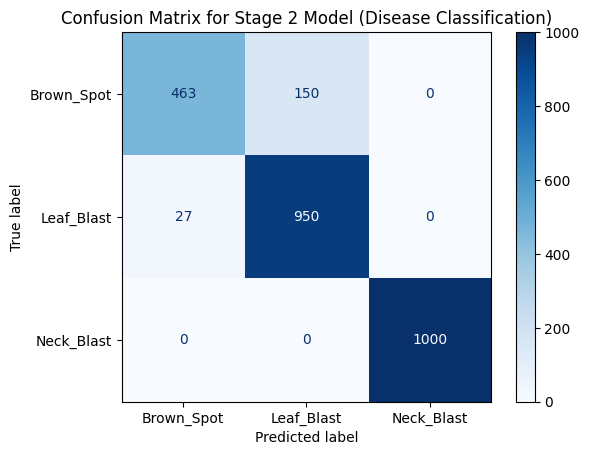

In [36]:
import os
from PIL import Image
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Set model to evaluation mode
model_stage2.eval()

# Function to classify a single image into disease categories
def classify_single_image_stage2(image_path, model, transform):
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)  # Add batch dimension
    image = image.to(device)

    with torch.no_grad():
        output = model(image)
        _, pred = torch.max(output, 1)

    return pred.item()  # 0: Brown_Spot, 1: Leaf_Blast, 2: Neck_Blast

# Initialize lists to store true and predicted labels
true_labels_stage2 = []
predicted_labels_stage2 = []

# Directory path for Unhealthy subfolders
unhealthy_dir_stage2 = 'Rice 2/Unhealthy'

# Classify images in each subfolder (Brown_Spot, Leaf_Blast, Neck_Blast)
for subfolder in ['Brown_Spot', 'Leaf_Blast', 'Neck_Blast']:
    folder_path = os.path.join(unhealthy_dir_stage2, subfolder)
    
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            true_labels_stage2.append(['Brown_Spot', 'Leaf_Blast', 'Neck_Blast'].index(subfolder))  # Assign true labels
            predicted_labels_stage2.append(classify_single_image_stage2(file_path, model_stage2, transform))

# Generate confusion matrix
conf_matrix_stage2 = confusion_matrix(true_labels_stage2, predicted_labels_stage2, labels=[0, 1, 2])

# Display the confusion matrix
disp_stage2 = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_stage2, display_labels=["Brown_Spot", "Leaf_Blast", "Neck_Blast"])
disp_stage2.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Stage 2 Model (Disease Classification)")
plt.show()


In [10]:
def classify_image(image_path):
    # Load and preprocess the image
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension and send to device

    # Stage 1: Healthy vs Unhealthy
    with torch.no_grad():
        output_stage1 = model_stage1(image)
        _, pred_stage1 = torch.max(output_stage1, 1)

    # Check result from Stage 1
    if pred_stage1.item() == 0:
        return "Healthy"
    else:
        # Stage 2: Disease classification (Unhealthy subtypes)
        with torch.no_grad():
            output_stage2 = model_stage2(image)
            _, pred_stage2 = torch.max(output_stage2, 1)
            classes_stage2 = ['Brown_Spot', 'Leaf_Blast', 'Neck_Blast']
            return classes_stage2[pred_stage2.item()]


In [17]:
resnet_model = models.resnet50(weights='DEFAULT')
vit_model = AutoModelForImageClassification.from_pretrained("google/vit-base-patch16-224")
model_stage1 = CombinedModel(resnet_model, vit_model, num_classes=2).to(device)
model_stage1.load_state_dict(torch.load('healthy_unhealthy_model.pth', map_location=device))
model_stage1.eval()

C:\Users\Dell\AppData\Local\Temp\ipykernel_12364\2870046870.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_stage1.load_state_dict(torch.load('healthy_unhealthy_mo

CombinedModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
     

In [24]:
model_stage2 = CombinedModel(resnet_model, vit_model, num_classes=3).to(device)
model_stage2.load_state_dict(torch.load('disease_classification_model.pth', map_location=device))
model_stage2.eval()

C:\Users\Dell\AppData\Local\Temp\ipykernel_12364\1977648650.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_stage2.load_state_dict(torch.load('disease_classificati

CombinedModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
     

In [32]:
image_path = r'Rice 2\Unhealthy\Leaf_Blast\IMG_3104.jpg'  # Change this path as needed
classification = classify_image(image_path)
print(f"Classification Result: {classification}")

Classification Result: Leaf_Blast
